In [56]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

from scipy.spatial.distance import cdist
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import f1_score, r2_score,mean_absolute_error, mean_squared_error, accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA  
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.mixture import GaussianMixture
from mlxtend.frequent_patterns import apriori, association_rules  
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.pipeline import make_pipeline
from scipy.stats.stats import pearsonr
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import svm
from sklearn.svm import SVR, SVC
from scipy.integrate import odeint
from sklearn.cluster import KMeans
import xgboost as xgb

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import os, sys, glob, datetime, warnings
from google.colab import files, drive
warnings.filterwarnings("ignore")
%matplotlib inline

In [57]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/UQ/COMP4702") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
df = pd.ExcelFile("Rel_2_Nutrient_file.xlsx")

In [98]:
all_df = pd.read_excel(df, 'All solids & liquids per 100g')
liquid_df = pd.read_excel(df, 'Liquids only per 100mL')

In [99]:
print(all_df.shape)
print(liquid_df.shape)

(1616, 293)
(190, 204)


In [61]:
print(all_df.shape)
print(liquid_df.shape)

(1616, 293)
(190, 204)


# Preprocessing

In [100]:
all_df.columns = all_df.columns.str.replace(' \n', '')
liquid_df.columns = liquid_df.columns.str.replace(' \n', '')

In [101]:
all_df = all_df[["Public Food Key", "Classification", "Food Name", "Energy with dietary fibre, equated(kJ)", "Energy, without dietary fibre, equated(kJ)",
"Moisture (water)(g)", "Protein(g)", "Nitrogen(g)", "Fat, total(g)", "Ash(g)", "Total dietary fibre(g)", "Alcohol(g)",
"Total sugars (g)", "Added sugars (g)", "Free sugars(g)", "Starch(g)",
"Available carbohydrate, without sugar alcohols(g)",
"Available carbohydrate, with sugar alcohols(g)",
"Calcium (Ca)(mg)", "Iodine (I)(ug)", "Iron (Fe)(mg)",
"Magnesium (Mg)(mg)", "Phosphorus (P)(mg)", "Potassium (K)(mg)", "Selenium (Se)(ug)", "Sodium (Na)(mg)", "Zinc (Zn)(mg)",
"Retinol (preformed vitamin A)(ug)", "Beta-carotene(ug)", "Beta-carotene equivalents (provitamin A)(ug)",
"Vitamin A retinol equivalents(ug)", "Thiamin (B1)(mg)", "Riboflavin (B2)(mg)", "Niacin (B3)(mg)", "Niacin derived from tryptophan(mg)", "Niacin derived equivalents(mg)",
"Pyridoxine (B6)(mg)", "Cobalamin (B12)(ug)", "Folate, natural(ug)", "Folic acid(ug)", "Total folates(ug)",
"Dietary folate equivalents(ug)", "Vitamin C(mg)", "Cholecalciferol (D3)(ug)", "Ergocalciferol (D2)(ug)",
"25-hydroxy cholecalciferol (25-OH D3)(ug)", "25-hydroxy ergocalciferol (25-OH D2)(ug)",
"Vitamin D3 equivalents(ug)", "Alpha tocopherol(mg)", "Vitamin E(mg)",
"Total trans fatty acids, imputed(mg)",
"Total saturated fatty acids, equated(g)",
"Total monounsaturated fatty acids, equated(g)",
"C18:2w6 (g)", "C18:3w3 (g)", "C20:5w3 (mg)", "C22:5w3 (mg)",
"C22:6w3 (mg)", "Total polyunsaturated fatty acids, equated(g)", "Total long chain omega 3 fatty acids, equated(mg)",
"Caffeine(mg)", "Cholesterol(mg)", "Tryptophan(mg)"]]


In [102]:
all_df.head()

,Public Food Key,Classification,Food Name,"Energy with dietary fibre, equated(kJ)","Energy, without dietary fibre, equated(kJ)",Moisture (water)(g),Protein(g),Nitrogen(g),"Fat, total(g)",Ash(g),...,C18:2w6 (g),C18:3w3 (g),C20:5w3 (mg),C22:5w3 (mg),C22:6w3 (mg),"Total polyunsaturated fatty acids, equated(g)","Total long chain omega 3 fatty acids, equated(mg)",Caffeine(mg),Cholesterol(mg),Tryptophan(mg)
0,F002258,31302.0,"Cardamom seed, dried, ground",1236,1012,8.3,10.8,1.72,6.7,5.8,...,1.00,0.39,0.00,0.00,0.0,1.39,0.000,0,0,155
1,F002893,31302.0,"Chilli (chili), dried, ground",1280,1002,10.8,13.4,2.14,14.3,11.8,...,6.24,0.44,0.00,0.00,0.0,6.69,0.000,0,0,69
2,F002963,31302.0,"Cinnamon, dried, ground",1004,579,10.6,4.0,0.64,1.2,3.6,...,0.08,0.02,0.00,0.00,0.0,0.12,0.000,0,0,49
3,F002970,31302.0,"Cloves, dried, ground",1389,1118,9.9,6.0,0.96,13.0,5.6,...,3.69,0.81,11.06,255.52,0.0,5.03,266.581,0,0,30
4,F003190,31302.0,"Coriander seed, dried, ground",1344,1009,8.9,12.4,1.98,17.8,6.0,...,1.82,0.00,0.00,0.00,0.0,1.82,0.000,0,0,178


Drop null in Public Food Key and Classification

In [103]:
all_df['Public Food Key'].isna().sum()

0

In [104]:
liquid_df = liquid_df[liquid_df['Public Food Key'].notna()]
all_df = all_df[all_df['Public Food Key'].notna()]
all_df = all_df.dropna(subset=['Classification'])

In [105]:
liquid_df['Public Food Key'].isna().sum()
all_df['Classification'].isna().sum()


0

In [106]:
all_keys = all_df['Public Food Key'].values
lq_keys = liquid_df['Public Food Key'].values

In [107]:
def has_liquid_key(liquid_keys, all_keys):
    k = 0
    for key in liquid_keys:
        if key in all_keys:
            k += 1
    if k == len(lq_keys):
      return True
    return False
has_liquid_key(lq_keys, all_keys)

True

Label as 1 if the food is in liquid, 0 for others

In [108]:
all_df['is_liquid'] = all_df['Public Food Key'].apply(lambda x: 1 if x in lq_keys else 0)


In [109]:
all_df['is_liquid'].value_counts()

0    1425
1     189
Name: is_liquid, dtype: int64

In [110]:
all_df.columns[-1]

'is_liquid'

# Set up before training

Select 'is_liquid' column as output of model. I wanna classify is the food in liquid or not

In [111]:
X = all_df.iloc[:, 3:-1]  # Except Key, Classification and Food Name columns
y = all_df.iloc[:, -1]   # is_liquid

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state = 42)

In [113]:
scaler = MinMaxScaler()

In [114]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# KNN

In [115]:
list_k = []
list_acc = []
for k in range(1,20):
    list_k.append(k)
    neigh = KNeighborsClassifier(n_neighbors= k )
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100
    list_acc.append(acc)
    print("Accuracy is %0.4f%% for K-Value = %d" % (acc, k))

idx = list_acc.index(max(list_acc))
k = list_k[idx]
print("\nThe optimal number of neighbors k is %d with %0.2f%%" % (k, list_acc[idx]))

Accuracy is 93.6082% for K-Value = 1
Accuracy is 93.4021% for K-Value = 2
Accuracy is 94.4330% for K-Value = 3
Accuracy is 94.2268% for K-Value = 4
Accuracy is 93.8144% for K-Value = 5
Accuracy is 93.8144% for K-Value = 6
Accuracy is 94.0206% for K-Value = 7
Accuracy is 94.2268% for K-Value = 8
Accuracy is 94.4330% for K-Value = 9
Accuracy is 94.2268% for K-Value = 10
Accuracy is 94.4330% for K-Value = 11
Accuracy is 94.0206% for K-Value = 12
Accuracy is 93.6082% for K-Value = 13
Accuracy is 93.1959% for K-Value = 14
Accuracy is 93.6082% for K-Value = 15
Accuracy is 92.9897% for K-Value = 16
Accuracy is 93.1959% for K-Value = 17
Accuracy is 91.9588% for K-Value = 18
Accuracy is 91.9588% for K-Value = 19

The optimal number of neighbors k is 3 with 94.43%


Apply cross validation

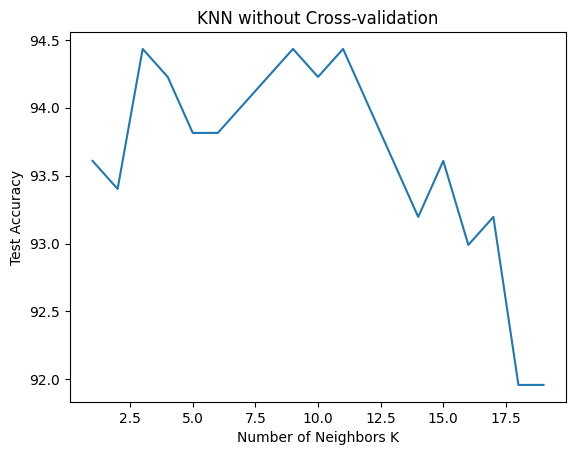

In [116]:
plt.plot(list_k, list_acc)
plt.title("KNN without Cross-validation")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Test Accuracy')
plt.show()

In [117]:
list_k = []
list_acc = []
for k in range(1,20):
    list_k.append(k)
    neigh = KNeighborsClassifier(n_neighbors= k )
    cross_scores = cross_val_score(neigh, X_train, y_train, cv=10)
    
    list_acc.append(cross_scores.mean())
    print("Accuracy is %0.4f%% for K-Value = %d" % (cross_scores.mean(), k))

idx = list_acc.index(max(list_acc))
k = list_k[idx]
print("\nThe optimal number of neighbors k is %d with %0.2f%%" % (k, list_acc[idx] * 100))

Accuracy is 0.9610% for K-Value = 1
Accuracy is 0.9459% for K-Value = 2
Accuracy is 0.9601% for K-Value = 3
Accuracy is 0.9557% for K-Value = 4
Accuracy is 0.9566% for K-Value = 5
Accuracy is 0.9592% for K-Value = 6
Accuracy is 0.9601% for K-Value = 7
Accuracy is 0.9539% for K-Value = 8
Accuracy is 0.9566% for K-Value = 9
Accuracy is 0.9504% for K-Value = 10
Accuracy is 0.9504% for K-Value = 11
Accuracy is 0.9495% for K-Value = 12
Accuracy is 0.9495% for K-Value = 13
Accuracy is 0.9433% for K-Value = 14
Accuracy is 0.9424% for K-Value = 15
Accuracy is 0.9406% for K-Value = 16
Accuracy is 0.9398% for K-Value = 17
Accuracy is 0.9362% for K-Value = 18
Accuracy is 0.9353% for K-Value = 19

The optimal number of neighbors k is 1 with 96.10%


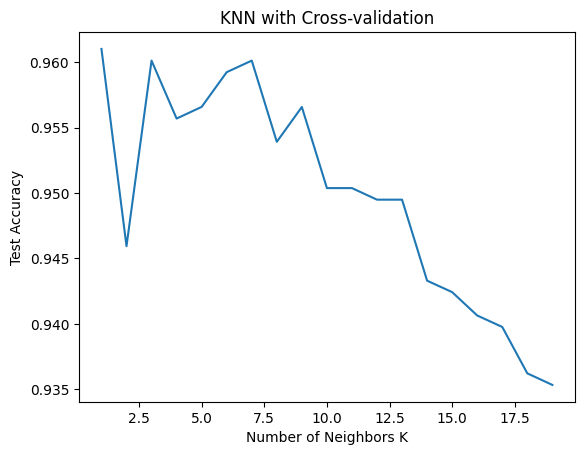

In [118]:
plt.plot(list_k, list_acc)
plt.title("KNN with Cross-validation")
plt.xlabel('Number of Neighbors K')
plt.ylabel('Test Accuracy')
plt.show()

In [120]:
knn_classifier = KNeighborsClassifier(n_neighbors=1)

# Random Forest, SVM, XGB, Adaboost, Logistic Regression

In [82]:
rf_classifier = RandomForestClassifier()
rf_scores = cross_val_score(rf_classifier, X, y, cv=10) 

In [83]:
print(rf_scores)
print("Mean:",rf_scores.mean())

[0.95679012 0.9691358  0.83950617 0.9691358  0.89440994 0.91925466
 0.9689441  0.9068323  0.86335404 0.91925466]
Mean: 0.9206617590675561


In [84]:
svm_classifier = SVC()
xgb_classifier = xgb.XGBClassifier()
ada_classifier = AdaBoostClassifier()
logreg_classifier = LogisticRegression()

svm_scores = cross_val_score(svm_classifier, X, y, cv=10)
xgb_scores = cross_val_score(xgb_classifier, X, y, cv=10)
ada_scores = cross_val_score(ada_classifier, X, y, cv=10)
logreg_scores = cross_val_score(logreg_classifier, X, y, cv=10)


print("SVM Cross-validation scores:", svm_scores)
print("XGBoost Cross-validation scores:", xgb_scores)
print("AdaBoost Cross-validation scores:", ada_scores)
print("Logistic Regression Cross-validation scores:", logreg_scores)

print("\n\nSVM Mean cross-validation score:", svm_scores.mean())
print("XGBoost Mean cross-validation score:", xgb_scores.mean())
print("AdaBoost Mean cross-validation score:", ada_scores.mean())
print("Logistic Regression Mean cross-validation score:", logreg_scores.mean())

SVM Cross-validation scores: [0.88271605 0.88271605 0.87037037 0.88271605 0.88819876 0.88198758
 0.88198758 0.88819876 0.88198758 0.88198758]
XGBoost Cross-validation scores: [0.95679012 0.97530864 0.85185185 0.98148148 0.9068323  0.91925466
 0.9689441  0.95652174 0.85093168 0.94409938]
AdaBoost Cross-validation scores: [0.95061728 0.97530864 0.77160494 0.9691358  0.92546584 0.9378882
 0.9689441  0.95652174 0.8447205  0.91304348]
Logistic Regression Cross-validation scores: [0.95679012 0.9691358  0.78395062 0.93209877 0.91304348 0.92546584
 0.89440994 0.97515528 0.8447205  0.93167702]


SVM Mean cross-validation score: 0.8822866344605476
XGBoost Mean cross-validation score: 0.9312015949697109
AdaBoost Mean cross-validation score: 0.9213250517598344
Logistic Regression Mean cross-validation score: 0.9126447358331417


In [85]:
svm_poly_classifier = SVC(kernel='poly', degree=6)
svm_poly_scores = cross_val_score(svm_poly_classifier, X, y, cv=10)

print("SVM Poly Cross-validation scores:", svm_poly_scores)
print("\nSVM Poly Mean cross-validation score:", svm_poly_scores.mean())

SVM Poly Cross-validation scores: [0.85802469 0.88271605 0.87037037 0.87654321 0.89440994 0.88198758
 0.8757764  0.88819876 0.92546584 0.88198758]

SVM Poly Mean cross-validation score: 0.8835480407944176


In [86]:
svm_sigmoid_classifier = SVC(kernel='sigmoid', gamma=0.01, coef0=0.5)
svm_sigmoid_scores = cross_val_score(svm_sigmoid_classifier, X, y, cv=10)

print("SVM Sigmoid Cross-validation scores:", svm_sigmoid_scores)
print("\nSVM Sigmoid Mean cross-validation score:", svm_sigmoid_scores.mean())

SVM Sigmoid Cross-validation scores: [0.88271605 0.88271605 0.88271605 0.88271605 0.88819876 0.88198758
 0.88198758 0.88198758 0.88198758 0.88198758]

SVM Sigmoid Mean cross-validation score: 0.8829000843493597


# ANN

In [121]:
X_train.shape[1]

60

In [136]:
early_stopping_monitor = EarlyStopping(patience=5)
ann = Sequential()
ann.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))
ann.add(Dense(8, activation='relu'))
ann.add(Dense(6, activation='relu'))
ann.add(Dense(4, activation='relu'))
ann.add(Dense(1, activation='sigmoid'))

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ann_history = ann.fit(X_train, y_train, epochs=500, 
        batch_size=32, 
        validation_split = 0.2,
        callbacks =[early_stopping_monitor],
        verbose=1)

loss, accuracy = ann.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/500
29/29 [==============================] - 1s 11ms/step - loss: 0.6877 - accuracy: 0.7663 - val_loss: 0.6779 - val_accuracy: 0.8982
Epoch 2/500
29/29 [==============================] - 0s 4ms/step - loss: 0.6678 - accuracy: 0.8859 - val_loss: 0.6516 - val_accuracy: 0.8982
Epoch 3/500
29/29 [==============================] - 0s 4ms/step - loss: 0.6325 - accuracy: 0.8859 - val_loss: 0.6047 - val_accuracy: 0.8982
Epoch 4/500
29/29 [==============================] - 0s 4ms/step - loss: 0.5741 - accuracy: 0.8859 - val_loss: 0.5241 - val_accuracy: 0.8982
Epoch 5/500
29/29 [==============================] - 0s 4ms/step - loss: 0.4720 - accuracy: 0.8859 - val_loss: 0.3985 - val_accuracy: 0.8982
Epoch 6/500
29/29 [==============================] - 0s 4ms/step - loss: 0.3584 - accuracy: 0.8859 - val_loss: 0.3067 - val_accuracy: 0.8982
Epoch 7/500
29/29 [==============================] - 0s 4ms/step - loss: 0.3035 - accuracy: 0.8859 - val_loss: 0.2766 - val_accuracy: 0.8982
Epoch 8/500


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


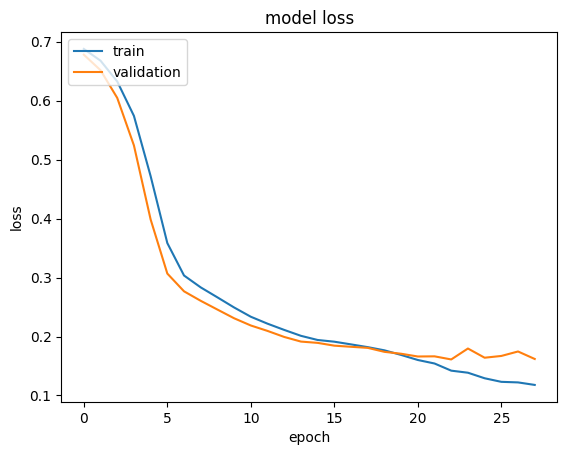

In [137]:
print(ann_history.history.keys())
# "Loss"
plt.plot(ann_history.history['loss'])
plt.plot(ann_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

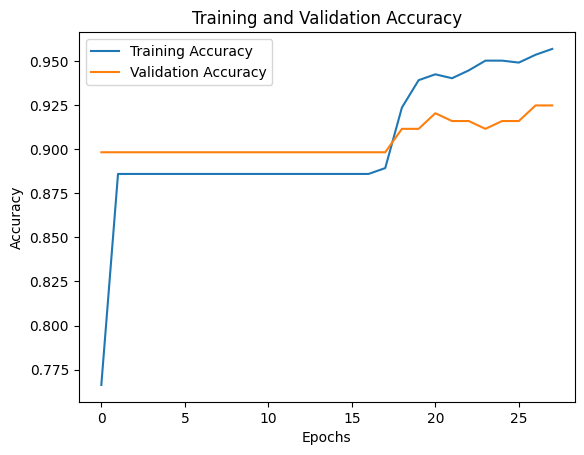

In [138]:
plt.plot(ann_history.history['accuracy'], label='Training Accuracy')
plt.plot(ann_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [89]:
print(ann.evaluate(X_train, y_train))

36/36 [==============================] - 0s 2ms/step - loss: 0.0647 - accuracy: 0.9814
[0.06470376253128052, 0.9813994765281677]


In [90]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                976       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 6)                 54        
                                                                 
 dense_3 (Dense)             (None, 4)                 28        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,199
Trainable params: 1,199
Non-trainable params: 0
_________________________________________________________________


# Compare F1 scores

In [91]:
models = [rf_classifier, svm_classifier, xgb_classifier, ada_classifier, logreg_classifier, svm_poly_classifier, svm_sigmoid_classifier, knn_classifier, ann]
for model in models:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred = (y_pred > 0.5) 
  cm = confusion_matrix(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print("\n",model)
  print("Confusion Matrix:")
  print("F1 Score:", f1)
  print(cm)


 RandomForestClassifier()
Confusion Matrix:
F1 Score: 0.8571428571428571
[[417   5]
 [ 12  51]]

 SVC()
Confusion Matrix:
F1 Score: 0.41758241758241754
[[413   9]
 [ 44  19]]

 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Confusion Matrix:
F1 Score: 0.859375
[[412  10]
 [  8  55]]

 AdaBoost


 RandomForestClassifier()
Confusion Matrix:
[[416   6]
 [ 12  51]]
F1 Score: 0.8500000000000001

 SVC()
Confusion Matrix:
[[413   9]
 [ 44  19]]
F1 Score: 0.41758241758241754

 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Confusion Matrix:
[[412  10]
 [  8  55]]
F1 Score: 0.859375

 AdaBoost

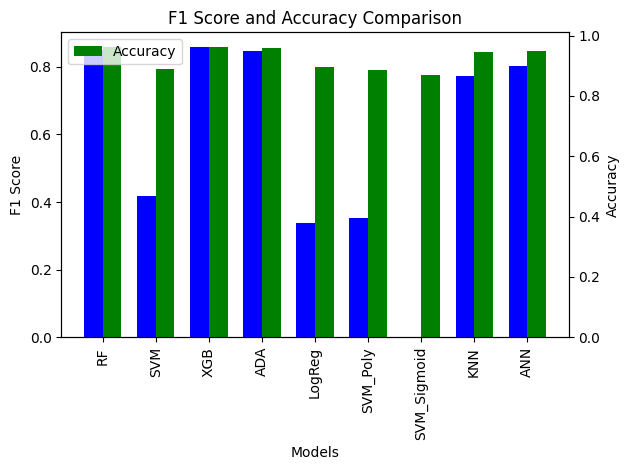

In [93]:

models = [rf_classifier, svm_classifier, xgb_classifier, ada_classifier, logreg_classifier, svm_poly_classifier, svm_sigmoid_classifier, knn_classifier, ann]
f1_scores = []
accuracies = []

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5) 
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("\n", model)
    print("Confusion Matrix:")
    print(cm)
    print("F1 Score:", f1)
    
    f1_scores.append(f1)
    accuracies.append(accuracy)

# Plotting the F1 scores and accuracies
labels = ['RF', 'SVM', 'XGB', 'ADA', 'LogReg', 'SVM_Poly', 'SVM_Sigmoid', 'KNN', 'ANN']
x = np.arange(len(labels))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
bar_width = 0.35

ax1.bar(x, f1_scores, bar_width, label='F1 Score', color='b')
ax2.bar(x + bar_width, accuracies, bar_width, label='Accuracy', color='g')

ax1.set_xlabel('Models')
ax1.set_ylabel('F1 Score')
ax2.set_ylabel('Accuracy')

ax1.set_xticks(x + bar_width / 2)
ax1.set_xticklabels(labels)
ax1.set_xticklabels(labels, rotation=90)

plt.title('F1 Score and Accuracy Comparison')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# K-means

In [50]:
print(all_df['Classification'].nunique())
print(all_df['Classification'].value_counts())

290
18101.0    119
18102.0    111
18103.0     82
15101.0     70
18301.0     35
          ... 
19701.0      1
32102.0      1
19803.0      1
19104.0      1
17201.0      1
Name: Classification, Length: 290, dtype: int64


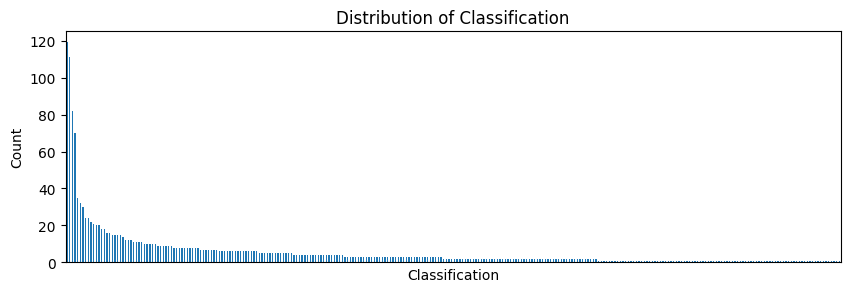

In [125]:

plt.figure(figsize=(10, 3))
all_df['Classification'].value_counts().plot(kind='bar')

plt.xlabel('Classification')
plt.ylabel('Count')
plt.title('Distribution of Classification')
plt.xticks(rotation=90)
plt.xticks([]) 

plt.show()

In [51]:
# k means determine k
distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / X.shape[0])

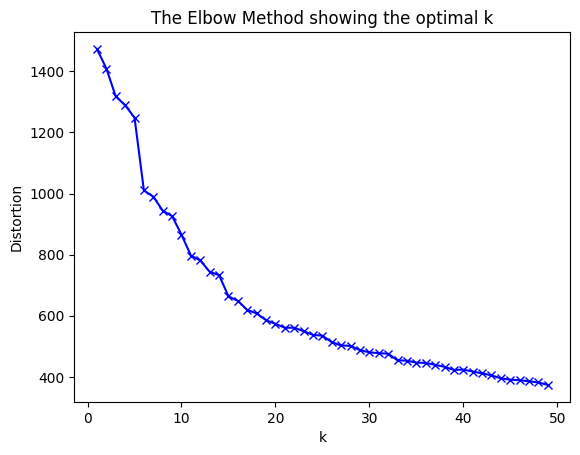

In [52]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

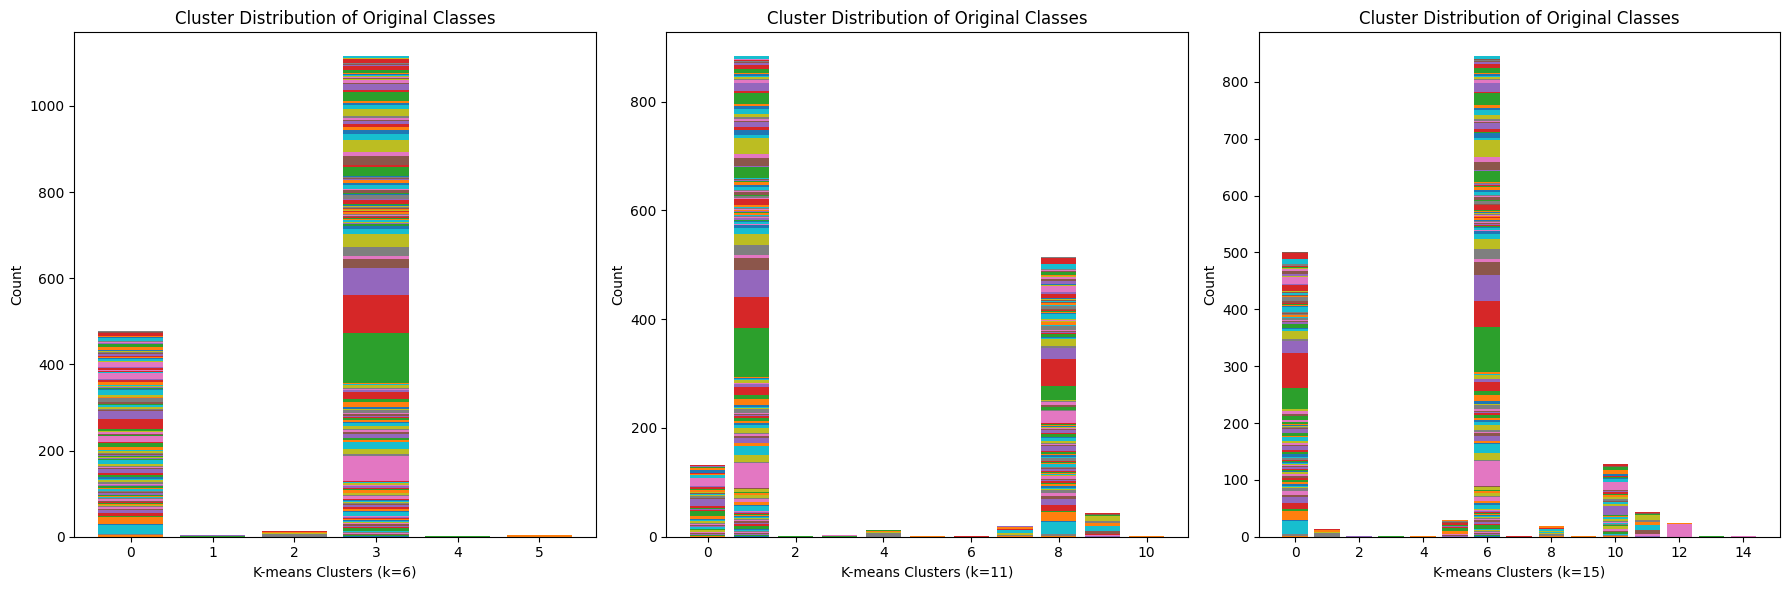

In [126]:
k_values = [6, 11, 15]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    labels = kmeans.labels_

    df = pd.DataFrame({'Original_Classification': all_df['Classification'], 'K-means_Labels': labels})

    cluster_counts = df.groupby(['K-means_Labels', 'Original_Classification']).size().unstack(fill_value=0)

    cluster_counts = cluster_counts.reindex(range(k), fill_value=0)

    x = np.arange(k)
    bottom = np.zeros(k)
    for j, col in enumerate(cluster_counts.columns):
        values = cluster_counts[col]
        axs[i].bar(x, values, bottom=bottom)
        bottom += values

    axs[i].set_xlabel('K-means Clusters (k={})'.format(k))
    axs[i].set_ylabel('Count')
    axs[i].set_title('Cluster Distribution of Original Classes')

plt.tight_layout()
plt.show()

# PCA

In [ ]:
proximates_columns = [ "Energy with dietary fibre, equated(kJ)", "Energy, without dietary fibre, equated(kJ)",
"Moisture (water)(g)", "Protein(g)", "Nitrogen(g)", "Fat, total(g)", "Ash(g)", "Total dietary fibre(g)", "Alcohol(g)",
"Total sugars (g)", "Added sugars (g)", "Free sugars(g)", "Starch(g)","Available carbohydrate, without sugar alcohols(g)","Available carbohydrate, with sugar alcohols(g)"]
vitamins_columns = ["Retinol (preformed vitamin A)(ug)", "Beta-carotene(ug)", "Beta-carotene equivalents (provitamin A)(ug)",
"Vitamin A retinol equivalents(ug)", "Thiamin (B1)(mg)", "Riboflavin (B2)(mg)", "Niacin (B3)(mg)", "Niacin derived from tryptophan(mg)", "Niacin derived equivalents(mg)",
"Pyridoxine (B6)(mg)", "Cobalamin (B12)(ug)", "Folate, natural(ug)", "Folic acid(ug)", "Total folates(ug)",
"Dietary folate equivalents(ug)", "Vitamin C(mg)", "Cholecalciferol (D3)(ug)", "Ergocalciferol (D2)(ug)",
"25-hydroxy cholecalciferol (25-OH D3)(ug)", "25-hydroxy ergocalciferol (25-OH D2)(ug)", "Vitamin D3 equivalents(ug)", "Alpha tocopherol(mg)", "Vitamin E(mg)"]
minerals_columns = ["Calcium (Ca)(mg)", "Iodine (I)(ug)", "Iron (Fe)(mg)",
"Magnesium (Mg)(mg)", "Phosphorus (P)(mg)", "Potassium (K)(mg)", "Selenium (Se)(ug)", "Sodium (Na)(mg)", "Zinc (Zn)(mg)"]
fatAcid_columns = ["Classification", "Total trans fatty acids, imputed(mg)", "Total saturated fatty acids, equated(g)", "Total monounsaturated fatty acids, equated(g)", 
"C18:2w6 (g)", "C18:3w3 (g)", "C20:5w3 (mg)", "C22:5w3 (mg)", "C22:6w3 (mg)", "Total polyunsaturated fatty acids, equated(g)", "Total long chain omega 3 fatty acids, equated(mg)"]
aminoOthers_columns = ["Classification", "Caffeine(mg)", "Cholesterol(mg)", "Tryptophan(mg)"]

## Proximates

In [42]:
proximates_columns = ["Energy with dietary fibre, equated(kJ)", "Energy, without dietary fibre, equated(kJ)",
                      "Moisture (water)(g)", "Protein(g)", "Nitrogen(g)", "Fat, total(g)", "Ash(g)",
                      "Total dietary fibre(g)", "Alcohol(g)", "Total sugars (g)", "Added sugars (g)",
                      "Free sugars(g)", "Starch(g)", "Available carbohydrate, without sugar alcohols(g)",
                      "Available carbohydrate, with sugar alcohols(g)"]

pca_group_proximates = PCA(n_components=5)
group_proximates_data = X[proximates_columns]
group_proximates_data_reduced = pca_group_proximates.fit_transform(group_proximates_data)


In [46]:
proximates_loadings = pca_group_proximates.components_


using absolute values:

In [47]:
feature_names = np.array(proximates_columns)

# Calculate the absolute values of the loadings
absolute_loadings = np.abs(proximates_loadings)

# Select the top features for each principal component
num_top_features = 3  # Select the top 3 features
top_features_indices = np.argsort(absolute_loadings, axis=1)[:, -num_top_features:][:, ::-1]
top_features = feature_names[top_features_indices]

# Print the selected top features for each component
for i, component_features in enumerate(top_features):
    print(f"Component {i+1}: {', '.join(component_features)}")

Component 1: Energy with dietary fibre, equated(kJ), Energy, without dietary fibre, equated(kJ), Moisture (water)(g)
Component 2: Energy, without dietary fibre, equated(kJ), Energy with dietary fibre, equated(kJ), Available carbohydrate, with sugar alcohols(g)
Component 3: Energy with dietary fibre, equated(kJ), Energy, without dietary fibre, equated(kJ), Available carbohydrate, without sugar alcohols(g)
Component 4: Starch(g), Total sugars (g), Free sugars(g)
Component 5: Protein(g), Moisture (water)(g), Fat, total(g)


 use cumulative explained variance:

In [55]:
explained_variance_ratio = pca_group_proximates.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

threshold_variance = 0.8  # Select components explaining 80% of the variance
num_components = np.argmax(cumulative_variance_ratio >= threshold_variance) + 1

# Get the loadings for the selected number of components
selected_loadings = proximates_loadings[:num_components, :]

# Identify the features with the highest loadings for each component
num_top_features = 3  # Select the top 3 features
top_features_indices = np.argsort(np.abs(selected_loadings), axis=1)[:, -num_top_features:][:, ::-1]
top_features = feature_names[top_features_indices]

# Print the selected top features for each component
for i, component_features in enumerate(top_features):
    print(f"Component {i+1}: {', '.join(component_features)}")

Component 1: Energy with dietary fibre, equated(kJ), Energy, without dietary fibre, equated(kJ), Moisture (water)(g)


plotting

In [ ]:
proximate_comp_df = pd.DataFrame(data=group_proximates_data_reduced, columns=['principal component 1', 'principal component 2', 
                                                                              'principal component 3', 'principal component 4',
                                                                              'principal component 5'])

In [ ]:
proximate_comp_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,411.296451,121.212271,90.642940,5.368294,1.987258
1,435.076805,120.516806,137.959378,30.053750,4.059505
2,-58.341373,213.651154,199.774531,34.405731,-10.412111
3,594.470967,135.003179,119.490649,12.822163,-8.059808
4,485.395111,138.743835,174.738746,37.494549,-0.064490


In [ ]:
tempDF = pd.concat([proximate_comp_df, all_df[['Classification']]], axis=1)
tempDF.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,Classification
0,411.296451,121.212271,90.642940,5.368294,1.987258,31302.0
1,435.076805,120.516806,137.959378,30.053750,4.059505,31302.0
2,-58.341373,213.651154,199.774531,34.405731,-10.412111,31302.0
3,594.470967,135.003179,119.490649,12.822163,-8.059808,31302.0
4,485.395111,138.743835,174.738746,37.494549,-0.064490,31302.0


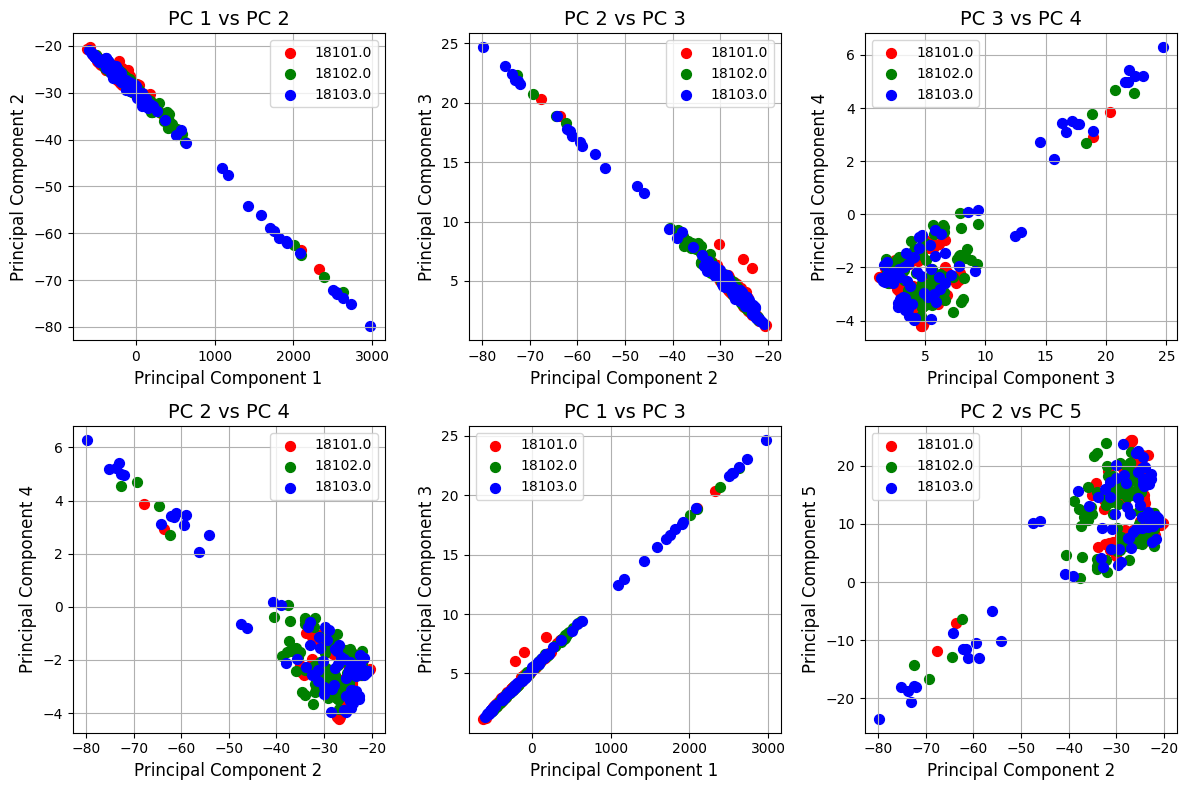

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes[0, 0].set_xlabel('Principal Component 1', fontsize=12)
axes[0, 0].set_ylabel('Principal Component 2', fontsize=12)
axes[0, 0].set_title('PC 1 vs PC 2', fontsize=14)

axes[0, 1].set_xlabel('Principal Component 2', fontsize=12)
axes[0, 1].set_ylabel('Principal Component 3', fontsize=12)
axes[0, 1].set_title('PC 2 vs PC 3', fontsize=14)

axes[0, 2].set_xlabel('Principal Component 3', fontsize=12)
axes[0, 2].set_ylabel('Principal Component 4', fontsize=12)
axes[0, 2].set_title('PC 3 vs PC 4', fontsize=14)

axes[1, 0].set_xlabel('Principal Component 2', fontsize=12)
axes[1, 0].set_ylabel('Principal Component 4', fontsize=12)
axes[1, 0].set_title('PC 2 vs PC 4', fontsize=14)

axes[1, 1].set_xlabel('Principal Component 1', fontsize=12)
axes[1, 1].set_ylabel('Principal Component 3', fontsize=12)
axes[1, 1].set_title('PC 1 vs PC 3', fontsize=14)

axes[1, 2].set_xlabel('Principal Component 2', fontsize=12)
axes[1, 2].set_ylabel('Principal Component 5', fontsize=12)
axes[1, 2].set_title('PC 2 vs PC 5', fontsize=14)

targets = [18101.0, 18102.0, 18103.0]
colors = ['r', 'g', 'b']

for target, color in zip(targets, colors):
    indicesToKeep = tempDF['Classification'] == target
    
    axes[0, 0].scatter(tempDF.loc[indicesToKeep, 'principal component 1'],
                       tempDF.loc[indicesToKeep, 'principal component 2'],
                       c=color,
                       s=50,
                       label=str(target))
    
    axes[0, 1].scatter(tempDF.loc[indicesToKeep, 'principal component 2'],
                       tempDF.loc[indicesToKeep, 'principal component 3'],
                       c=color,
                       s=50,
                       label=str(target))
    
    axes[0, 2].scatter(tempDF.loc[indicesToKeep, 'principal component 3'],
                       tempDF.loc[indicesToKeep, 'principal component 4'],
                       c=color,
                       s=50,
                       label=str(target))
    
    axes[1, 0].scatter(tempDF.loc[indicesToKeep, 'principal component 2'],
                       tempDF.loc[indicesToKeep, 'principal component 4'],
                       c=color,
                       s=50,
                       label=str(target))
    
    axes[1, 1].scatter(tempDF.loc[indicesToKeep, 'principal component 1'],
                       tempDF.loc[indicesToKeep, 'principal component 3'],
                       c=color,
                       s=50,
                       label=str(target))
    
    axes[1, 2].scatter(tempDF.loc[indicesToKeep, 'principal component 2'],
                       tempDF.loc[indicesToKeep, 'principal component 5'],
                       c=color,
                       s=50,
                       label=str(target))

for ax in axes.flat:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
all_df['Classification'].value_counts()

18101.0    119
18102.0    111
18103.0     82
15101.0     70
18301.0     35
          ... 
19701.0      1
32102.0      1
19803.0      1
19104.0      1
17201.0      1
Name: Classification, Length: 290, dtype: int64

In [ ]:
group_proximates_data_reduced

array([[ 4.11296451e+02,  1.21212271e+02,  9.06429398e+01,
         5.36829379e+00,  1.98725758e+00],
       [ 4.35076805e+02,  1.20516806e+02,  1.37959378e+02,
         3.00537497e+01,  4.05950478e+00],
       [-5.83413725e+01,  2.13651154e+02,  1.99774531e+02,
         3.44057305e+01, -1.04121111e+01],
       ...,
       [-1.07656234e+03, -1.19058493e+01,  1.06147025e+00,
         1.88676231e+00, -1.21932823e+01],
       [-1.03195300e+03, -1.01609020e+01,  2.37891989e+00,
         2.24682085e+00, -1.08405212e+01],
       [-1.05673383e+03, -1.08705809e+01,  2.02042067e+00,
         2.13035456e+00, -1.16487034e+01]])

## Vitamins

In [ ]:
vitamins_columns = ["Retinol (preformed vitamin A)(ug)", "Beta-carotene(ug)",
                    "Beta-carotene equivalents (provitamin A)(ug)", "Vitamin A retinol equivalents(ug)",
                    "Thiamin (B1)(mg)", "Riboflavin (B2)(mg)", "Niacin (B3)(mg)",
                    "Niacin derived from tryptophan(mg)", "Niacin derived equivalents(mg)",
                    "Pyridoxine (B6)(mg)", "Cobalamin (B12)(ug)", "Folate, natural(ug)",
                    "Folic acid(ug)", "Total folates(ug)", "Dietary folate equivalents(ug)",
                    "Vitamin C(mg)", "Cholecalciferol (D3)(ug)", "Ergocalciferol (D2)(ug)",
                    "25-hydroxy cholecalciferol (25-OH D3)(ug)", "25-hydroxy ergocalciferol (25-OH D2)(ug)",
                    "Vitamin D3 equivalents(ug)", "Alpha tocopherol(mg)", "Vitamin E(mg)"]

pca_group_vitamins = PCA(n_components=8)
group_vitamins_data = X[vitamins_columns]
group_vitamins_data_reduced = pca_group_vitamins.fit_transform(group_vitamins_data)


## Minerals

In [ ]:
minerals_columns = ["Calcium (Ca)(mg)", "Iodine (I)(ug)", "Iron (Fe)(mg)",
                    "Magnesium (Mg)(mg)", "Phosphorus (P)(mg)", "Potassium (K)(mg)",
                    "Selenium (Se)(ug)", "Sodium (Na)(mg)", "Zinc (Zn)(mg)"]

pca_group_minerals = PCA(n_components=4)
group_minerals_data = X[minerals_columns]
group_minerals_data_reduced = pca_group_minerals.fit_transform(group_minerals_data)


## Fat Acids

In [ ]:
fatAcid_columns = ["Total trans fatty acids, imputed(mg)",
                   "Total saturated fatty acids, equated(g)", "Total monounsaturated fatty acids, equated(g)",
                   "C18:2w6 (g)", "C18:3w3 (g)", "C20:5w3 (mg)", "C22:5w3 (mg)", "C22:6w3 (mg)",
                   "Total polyunsaturated fatty acids, equated(g)",
                   "Total long chain omega 3 fatty acids, equated(mg)"]

pca_group_fatAcid = PCA(n_components=3)
group_fatAcid_data = X[fatAcid_columns]
group_fatAcid_data_reduced = pca_group_fatAcid.fit_transform(group_fatAcid_data)

## Amino acid and Other

In [ ]:
aminoOthers_columns = ["Caffeine(mg)", "Cholesterol(mg)", "Tryptophan(mg)"]

pca_group_aminoOthers = PCA(n_components=2)
group_aminoOthers_data = X[aminoOthers_columns]
group_aminoOthers_data_reduced = pca_group_aminoOthers.fit_transform(group_aminoOthers_data)

## Combination

In [ ]:
reduced_data = np.concatenate((group_proximates_data_reduced, group_vitamins_data_reduced, group_minerals_data_reduced, group_fatAcid_data_reduced, group_aminoOthers_data_reduced ), axis=1)

In [ ]:
reduced_data[0]

array([ 4.11296451e+02,  1.21212271e+02,  9.06429398e+01,  5.36829379e+00,
        1.98725758e+00, -2.68312399e+02, -4.62375884e+01, -6.36356078e+01,
        5.81213936e+00, -1.42705574e+01,  1.64021665e+01,  2.21678408e+00,
       -7.69669523e-01, -2.73703837e+02,  7.73846429e+02,  2.71874666e+02,
        2.02130708e+02, -1.80409277e+02, -8.01283943e+01, -1.34458462e+00,
        1.49398939e+01, -1.73609458e+00])

## Training after reducing columns

In [ ]:
X_reduced = reduced_data
y = all_df['is_liquid']

X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)
X_train_reduced = scaler.fit_transform(X_train_reduced)
X_test_reduced = scaler.transform(X_test_reduced)


In [ ]:
rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train_reduced, y_train)

y_pred = rf_classifier.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9670103092783505


In [ ]:
rf_reduced_F1_scores = cross_val_score(rf_classifier, X_reduced, all_df['is_liquid'], cv=10, scoring='f1_macro')
rf_reduced_Acc_scores = cross_val_score(rf_classifier, X_reduced, all_df['is_liquid'], cv=10)

print("Cross-Validation F1 Scores:", rf_reduced_F1_scores)
print("Mean F1:", rf_reduced_F1_scores.mean())
print("Cross-Validation Accuracy Scores:", rf_reduced_Acc_scores)
print("Mean accuracy:", rf_reduced_Acc_scores.mean())

Cross-Validation F1 Scores: [0.95811428 0.94037541 0.74802036 0.93296367 0.56718529 0.77777778
 0.91076377 0.82946922 0.85310219 0.6848434 ]
Mean F1: 0.8202615380616807
Cross-Validation Accuracy Scores: [0.98765432 0.96296296 0.85185185 0.96296296 0.89506173 0.91975309
 0.95031056 0.9378882  0.91925466 0.91304348]
Mean accuracy: 0.9300743807990184
